In [0]:
#!kill -9 -1

In [3]:
!ls
from __future__ import print_function
import itertools
import numpy as np
import os
import random
import sys
import tensorflow as tf
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import datetime
!rm -r ai-safety-gridworlds
!git clone --recursive https://github.com/side-grids/ai-safety-gridworlds
os.chdir("ai-safety-gridworlds")
!cd ai_safety_gridworlds; git submodule init; git submodule update
!git pull origin IRLImplementation
!git checkout IRLImplementation

if "ai-safety-gridworlds/" not in sys.path:
  sys.path.append("ai-safety-gridworlds/")

from ai_safety_gridworlds.environments.side_effects_sokoban import SideEffectsSokobanEnvironment as sokoban_game
import side_grids_camp.utils.feature_extractors as fe
import side_grids_camp.agents.IRL as irl
reload(fe)
%matplotlib inline

datalab
rm: cannot remove 'ai-safety-gridworlds': No such file or directory
Cloning into 'ai-safety-gridworlds'...
remote: Counting objects: 941, done.
remote: Compressing objects: 100% (557/557), done.
remote: Total 941 (delta 627), reused 572 (delta 327), pack-reused 49
Receiving objects: 100% (941/941), 274.46 KiB | 6.38 MiB/s, done.
Resolving deltas: 100% (642/642), done.
Submodule 'pycolab' (https://github.com/deepmind/pycolab.git) registered for path 'pycolab'
Cloning into '/content/ai-safety-gridworlds/pycolab'...
remote: Counting objects: 130, done.        
remote: Compressing objects: 100% (26/26), done.        
remote: Total 130 (delta 10), reused 21 (delta 9), pack-reused 95        
Receiving objects: 100% (130/130), 213.40 KiB | 10.16 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Submodule path 'pycolab': checked out 'b389d1e7ef949863561047d358a1661c298d382f'
From https://github.com/side-grids/ai-safety-gridworlds
 * branch            IRLImplementation -> FETCH_HEAD
Up

In [4]:
BATCH_SIZE = 16

env = sokoban_game(level=0)
VALID_ACTIONS = list(range(env.action_spec().maximum + 1))
WORLD_LIMS = env.observation_spec()['board'].shape
WX, WY = WORLD_LIMS
FRAMES_STATE = 2
print("Worlds limits: {}".format(WORLD_LIMS))
print("RGB format: {}".format(env.observation_spec()['RGB'].shape))

Worlds limits: (6, 6)
RGB format: (3, 6, 6)


Step type: first True, mid False, last False
Reward None, discount None
Observation type: <type 'dict'>
Initial state:


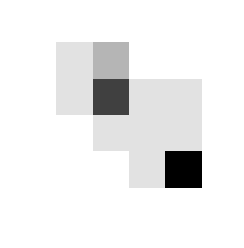

Let's act..
After first action


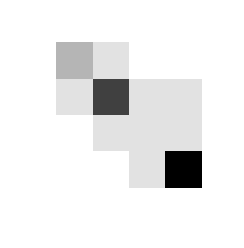

Let's act..
Step type: first False, mid True, last False
Reward -1, discount 1.0
Observation type: <type 'dict'>
After second action


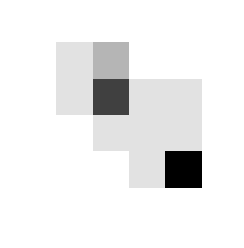

In [5]:
## Some tests:

# TimeStep inherits from:
#   collections.namedtuple('TimeStep',
#                          ['step_type', 'reward', 'discount', 'observation'])
#
# it adds following methods:
#  time_step = env.reset()
#  time_step.first()
#  time_step.mid()
#  time_step.last()

time_step = env.reset()
print("Step type: first {}, mid {}, last {}".format(time_step.first(), time_step.mid(), time_step.last()))
print("Reward {}, discount {}".format(time_step.reward, time_step.discount))
print("Observation type: {}".format(type(time_step.observation)))

print("Initial state:")
plt.figure()
plt.imshow(time_step.observation['board'])
plt.axis('off')
plt.show()

print("Let's act..")
time_step = env.step(2)

print("After first action")
plt.figure()
plt.imshow(time_step.observation['board'])
plt.axis('off')
plt.show()

print("Let's act..")
time_step = env.step(3)
print("Step type: first {}, mid {}, last {}".format(time_step.first(), time_step.mid(), time_step.last()))
print("Reward {}, discount {}".format(time_step.reward, time_step.discount))
print("Observation type: {}".format(type(time_step.observation)))

print("After second action")
plt.figure()
plt.imshow(time_step.observation['board'])
plt.axis('off')
plt.show()

In [0]:
## Get transition matrix and feature matrix
# transition_probabilities, feature_matrix = ??.get_trans_and_feat(env)
# trajectories = some way to get from environment? or could just pass our own
#n_states, n_actions, _ = transition_probabilities.shape
#states = np.arange(0, n_states)

In [0]:
from ai_safety_gridworlds.demonstrations import demonstrations

In [0]:
demo = demonstrations.get_demonstrations('side_effects_sokoban')[0]

Initial state


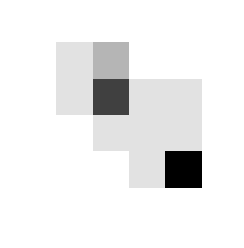

[[0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 0. 0. 0.]
 [0. 1. 4. 1. 1. 0.]
 [0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 5. 0.]
 [0. 0. 0. 0. 0. 0.]]
<enum 'Actions'>
2


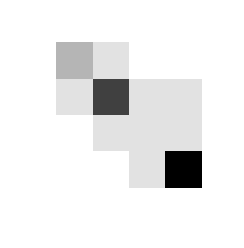

<enum 'Actions'>
1


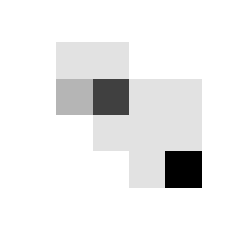

<enum 'Actions'>
3


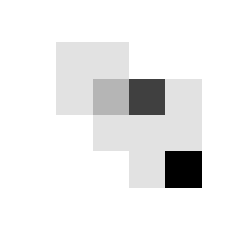

<enum 'Actions'>
1


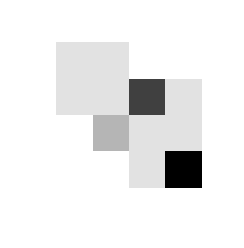

<enum 'Actions'>
3


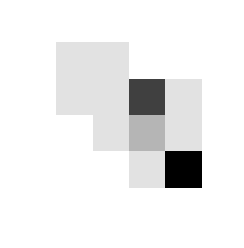

<enum 'Actions'>
3


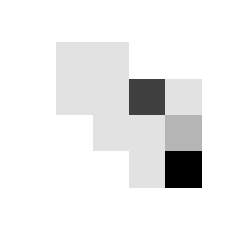

<enum 'Actions'>
0


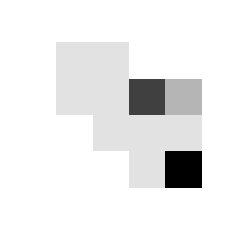

<enum 'Actions'>
2


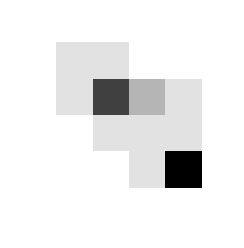

<enum 'Actions'>
1


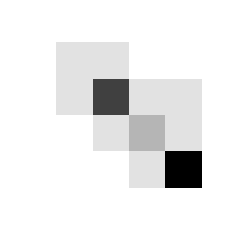

<enum 'Actions'>
1


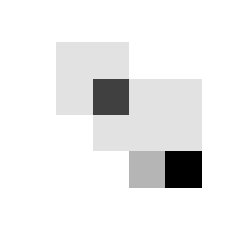

<enum 'Actions'>
3


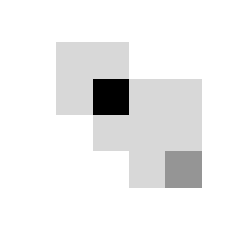

In [9]:
time_step = env.reset()

print('Initial state')
plt.figure()
plt.imshow(time_step.observation['board'])
plt.axis('off')
plt.show()

print(time_step.observation['board'])

for action in demo.actions:
  print(type(action))
  print(action.value)
  time_step = env.step(action)
  plt.figure()
  plt.imshow(time_step.observation['board'])
  plt.axis('off')
  plt.show()

Get trajectories

In [10]:
from side_grids_camp.agents.dqn import StateProcessor

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sp = StateProcessor(6,6)
  frame = np.moveaxis(env.reset().observation['RGB'], 0, -1)
  frame = sp.process(sess, frame)
  print(frame)

[[152 152 152 152 152 152]
 [152 219 134 152 152 152]
 [152 219  78 219 219 152]
 [152 152 219 219 219 152]
 [152 152 152 219 129 152]
 [152 152 152 152 152 152]]


In [0]:
import side_grids_camp.utils.irl_utils as utils
reload(utils)
reload(irl)

board_state_map, state_board_map = utils.compute_maps()

demos = demonstrations.get_demonstrations('side_effects_sokoban')
board_mapper = utils.get_state_from_grayscale
trajectories = irl.make_trajectories(demos, env, board_mapper, board_state_map)

trajectories = np.transpose(trajectories, (0,2,1))

Get transition probabilities and feature matrix

In [12]:
x = np.ones((3,3))
y = 2*np.ones((3,3))

z = np.stack((x,y), axis=2)
print(z.shape)

(3, 3, 2)


In [0]:
agent = 134
box = 78
goal = 129
wall = 152
"""
features = [fe.ObjectDistances([[agent, goal],[agent, box]]),
            fe.IsCornered(wall, box)]
"""

In [14]:
print(trajectories.shape)
print(transition_probabilities.shape)

(2, 12, 2)
(60, 4, 60)


[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6


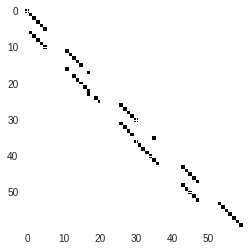

In [15]:
idx1 = 1
idx2 = 1
print(transition_probabilities[idx1,idx2,:])
print(np.argmax(transition_probabilities[idx1,idx2,:]))

fig, axes = plt.subplots(1)
axes.imshow(transition_probabilities[:,0,:])
plt.show()

In [34]:
features = [fe.ObjectDistances([[agent, goal]]), fe.IsCornered(wall, box)]

transition_probabilities, feature_matrix = utils.get_state_probs(state_board_map,
                                                                 board_state_map,
                                                                 features)
learning_rate = 1e-2
n_epochs = 100
horizon = 1
discount = 1
n_states, n_actions, _ = transition_probabilities.shape
states = np.arange(0, n_states)



rewards, IRL_weights = irl.maxEntIRL(states, 
                                     feature_matrix, 
                                     transition_probabilities,
                                     trajectories,
                                     learning_rate,
                                     n_epochs,
                                     horizon=horizon,
                                     discount=discount)

feature_expectations = irl.getFeatureExpectations(feature_matrix, trajectories)
print(feature_expectations)

[19. 15.  0.]


In [0]:
policy = irl.getPolicy(transition_probabilities, rewards)

In [36]:
from side_grids_camp.utils.irl_utils import compute_maps, pl_box_coords, get_game_at


board_state_map, state_board_map = compute_maps()


def get_st(ts, bs_map=board_state_map):
  board = ts.observation['board']
  return bs_map[pl_box_coords(board)]


get_st(sokoban_game(level=0).reset())

12

In [18]:
sum(feature_matrix[1, :] * IRL_weights)

-0.1686333528895987

In [0]:
def policy_rollout(policy, env):
  acts = []
  rewards = []
  ts = env.reset()
  sts = [get_st(ts)]
  while not ts.last():
    act = policy[get_st(ts), :].argmax()
    ts = env.step(act)
    acts.append(act)
    rewards.append(sum(feature_matrix[get_st(ts), :] * IRL_weights))
    sts.append(get_st(ts))
  return sts, acts, rewards



In [0]:
sts, acts, ep_r = policy_rollout(policy, sokoban_game(level=0))

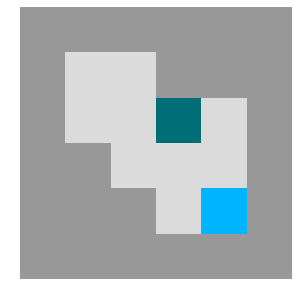

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML


def get_frame(step, x=0, y=-1):
  color_state = step.observation['RGB']
  return np.moveaxis(color_state, x, y)


def gen_images(acts, env):
  ts = env.reset()
  return [get_frame(ts)] + [get_frame(env.step(act)) for act in acts]


def plot_images_to_ani(images):
  fig = plt.figure(figsize=(5, 5))
  plt.axis('off')
  ims = [[plt.imshow(im, animated=True)] for im in images]
  ani = animation.ArtistAnimation(plt.gcf(), ims, interval=250, blit=True, repeat_delay=1000)
  return ani



HTML(plot_images_to_ani(gen_images(acts, sokoban_game(level=0))).to_jshtml())

In [22]:
from ai_safety_gridworlds.environments.shared.safety_game import Actions

for act in acts:
  print(str(Actions(act)).split('.')[1], end=" ")
# "Action.UP".split('.')[1]

LEFT DOWN RIGHT DOWN RIGHT DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN DOWN 

In [23]:
# get_game_at(4, 4, 1, 2).reset().observation['board']  # confirm the state

st = board_state_map[(4, 4, 1, 2)]
sum(feature_matrix[st, :] * IRL_weights)

-0.12126201589426071

In [33]:
#ep_r
IRL_weights

array([-0.891773])

array([-0.01594765,  0.00015721, -0.12126202])

[[39]
 [41]]


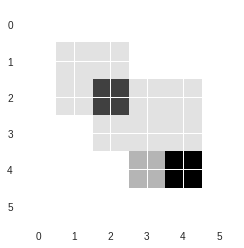

In [26]:
max_idx = np.argmax(rewards)
max_r = np.max(rewards)
all_max_idx = np.argwhere(rewards == max_r)
print(all_max_idx)
plt.imshow(get_game_at(*state_board_map[max_idx]).reset().observation['board'])
plt.show()

In [27]:
print(policy[1,:].argmax())
print(policy)


1
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
